본 코드는, 아래 링크에서 많은 영향을 받았습니다.

https://github.com/bentrevett/pytorch-seq2seq

::Transformer 기반으로, 독일어와 영어의 번역 시스템을 구축해보고자 합니다.

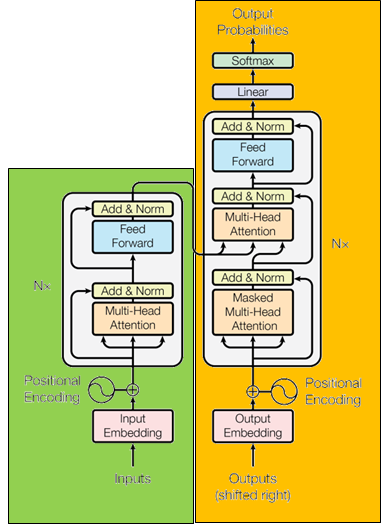

In [ ]:
import torch
import torch.nn as nn
import torch.optim as optim
import torchtext
from torchtext.legacy.datasets import Multi30k
from torchtext.legacy.data import Field, BucketIterator
import matplotlib.pyplot as plt
import matplotlib.ticker as ticker
import spacy
import spacy.cli 
spacy.cli.download("de_core_news_sm")
spacy.cli.download("en_core_web_sm")
import numpy as np
import random
import math
import time
from torchtext.data.metrics import bleu_score

✔ Download and installation successful
You can now load the model via spacy.load('de_core_news_sm')
✔ Download and installation successful
You can now load the model via spacy.load('en_core_web_sm')


모델의 재현성을 위하여 Random Seed를 고정하겠습니다.



In [ ]:
SEED = 1000
random.seed(SEED)
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False

각 언어별로, Tokenizer를 수행하겠습니다.

In [ ]:
spacy_de = spacy.load('de_core_news_sm')
spacy_en = spacy.load('en_core_web_sm')

In [ ]:
def tokenize_de(text):
    """
    Tokenizes German text from a string into a list of strings
    """
    return [tok.text for tok in spacy_de.tokenizer(text)]

def tokenize_en(text):
    """
    Tokenizes English text from a string into a list of strings
    """
    return [tok.text for tok in spacy_en.tokenizer(text)]

우리는 독일어에서 영어로 번역하기를 원합니다.

Source (독일어) 와 Target (영어) 데이터를 구축합니다.

데이터를 구축 할 때 batch dimension이 처음으로 나오도록 구현하겠습니다.

즉, [batch_size, max_length, hidden_dim] 으로 구성됩니다.

In [ ]:
SRC = Field(tokenize = tokenize_de, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

TRG = Field(tokenize = tokenize_en, 
            init_token = '<sos>', 
            eos_token = '<eos>', 
            lower = True, 
            batch_first = True)

Multi30k data를 불러와서, train, valid, test set으로 분류하고, voca 를 구성합니다. (min_freq=2)

In [ ]:
train_data, valid_data, test_data = Multi30k.splits(exts = ('.de', '.en'), 
                                                    fields = (SRC, TRG))
SRC.build_vocab(train_data, min_freq = 2)
TRG.build_vocab(train_data, min_freq = 2)

연산을 진행할 device를 설정하고, data iterator를 만들어줍니다. (여기서는 batch size 128)

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
BATCH_SIZE = 128

train_iterator, valid_iterator, test_iterator = BucketIterator.splits(
    (train_data, valid_data, test_data), 
     batch_size = BATCH_SIZE,
     device = device)

# A. Encoder

여기서는 Transformer의 Encoder를 구축합니다. (특정 블락이 아닌, n_layers 만큼의 전체 Encoder를 구축하는 부분입니다.)

편의상, positional encoding은 embedding lookup layer를 통해서, 학습하는 것으로 하겠습니다.

In [ ]:
class Encoder(nn.Module):
    def __init__(self, 
                 input_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim,
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()

        self.device = device
        self.tok_embedding = nn.Embedding(input_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([EncoderLayer(hid_dim, n_heads, pf_dim,dropout, device) for _ in range(n_layers)])
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len]
        #src_mask = [batch size, 1, 1, src len]
        batch_size = src.shape[0]
        src_len = src.shape[1]
        
        #pos = [batch size, src len]
        pos = torch.LongTensor([[j for j in range(src_len)] for i in range(batch_size)]).to(device)
        #pos = [[j for j in range(src_len)] for i in range(batch_size)]

        #src = [batch size, src len, hid dim]
        # src: input embedding에 scale을 곱해주고 positional encoding을 더해주세요.
        src = self.dropout((self.tok_embedding(src) * self.scale) + self.pos_embedding(pos))
        
        for layer in self.layers:
          src = layer(src, src_mask)
          
        #src = [batch size, src len, hid dim]
        return src


# A-1 Encoder Layer

이 부분은 Encoder Layer를 구축하는 부분입니다.

In [ ]:
class EncoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim,  
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, pf_dim, dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, src, src_mask):
        #src = [batch size, src len, hid dim]
        #src_mask = [batch size, 1, 1, src len] 

        #self attention
        src_MHA, attention = self.self_attention.forward(src,src,src,src_mask) #
        
        #dropout, residual connection and layer norm
        src = self.self_attn_layer_norm(src + self.dropout(src_MHA) )##
        
        #positionwise feedforward
        src_FF = self.positionwise_feedforward.forward(src)
        
        #dropout, residual and layer norm
        src = self.ff_layer_norm(src + self.dropout(src_FF) )##
        
        #src = [batch size, src len, hid dim]
        return src

# A-2.MultiHeadAttentionLayer
MultiHeadAttentionLayer를 구축합니다.

In [ ]:
class MultiHeadAttentionLayer(nn.Module):
    def __init__(self, hid_dim, n_heads, dropout, device):
        super().__init__()
        
        assert hid_dim % n_heads == 0
        
        self.hid_dim = hid_dim
        self.n_heads = n_heads
        self.head_dim = hid_dim // n_heads
        
        self.fc_q = nn.Linear(hid_dim, hid_dim)
        self.fc_k = nn.Linear(hid_dim, hid_dim)
        self.fc_v = nn.Linear(hid_dim, hid_dim)
        
        self.fc_o = nn.Linear(hid_dim, hid_dim)
        
        self.dropout = nn.Dropout(dropout)
        
        self.scale = torch.sqrt(torch.FloatTensor([self.head_dim])).to(device)
        
    def forward(self, query, key, value, mask = None):
        
        batch_size = query.shape[0]
        
        #query = [batch size, query len, hid dim]
        #key = [batch size, key len, hid dim]
        #value = [batch size, value len, hid dim]
        Q = self.fc_q(query)
        K = self.fc_k(key)
        V = self.fc_v(value)
        
        #Q = [batch size, query len, hid dim]
        #K = [batch size, key len, hid dim]
        #V = [batch size, value len, hid dim]
        Q = Q.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        K = K.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        V = V.view(batch_size, -1, self.n_heads, self.head_dim).permute(0, 2, 1, 3)
        #Q = [batch size, n heads, query len, head dim]
        #K = [batch size, n heads, key len, head dim]
        #V = [batch size, n heads, value len, head dim]
                
        energy = (torch.matmul(Q , torch.transpose(K,2,3))) / self.scale
        #energy = [batch size, n heads, query len, key len]
        
        if mask is not None:
            energy = energy.masked_fill(mask == 0, -1e10)
        
        softmax = nn.Softmax(dim=3)
        attention = softmax(energy)
        #attention = nn.functional.softmax(energy, dim=3)
        #attention = [batch size, n heads, query len, key len]
                
        x = torch.matmul(self.dropout(attention), V)
        #x = [batch size, n heads, query len, head dim]
        
        x = x.permute(0, 2, 1, 3).contiguous()
        #x = [batch size, query len, n heads, head dim]
        
        x = x.view(batch_size, -1, self.hid_dim)
        #x = [batch size, query len, hid dim]
        
        x = self.fc_o(x)
        #x = [batch size, query len, hid dim]
        
        return x, attention

# A-3 PositionwiseFeedforwardLayer

PositionwiseFeedforwardLayer

In [ ]:
class PositionwiseFeedforwardLayer(nn.Module):
    def __init__(self, hid_dim, pf_dim, dropout):
        super().__init__()
        
        self.fc_1 = nn.Linear(hid_dim, pf_dim)
        self.fc_2 = nn.Linear(pf_dim, hid_dim)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, x):
        
        #x = [batch size, seq len, hid dim]
        x = self.dropout(torch.relu(self.fc_1(x)))
        
        #x = [batch size, seq len, pf dim]
        x = self.fc_2(x)
        #x = [batch size, seq len, hid dim]
        
        return x

# B. Decoder

In [ ]:
class Decoder(nn.Module):
    def __init__(self, 
                 output_dim, 
                 hid_dim, 
                 n_layers, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device,
                 max_length = 100):
        super().__init__()
        
        self.device = device
        self.tok_embedding = nn.Embedding(output_dim, hid_dim)
        self.pos_embedding = nn.Embedding(max_length, hid_dim)
        self.layers = nn.ModuleList([DecoderLayer(hid_dim, 
                                                  n_heads, 
                                                  pf_dim, 
                                                  dropout, 
                                                  device)
                                     for _ in range(n_layers)])
        
        self.fc_out = nn.Linear(hid_dim, output_dim)
        self.dropout = nn.Dropout(dropout)
        self.scale = torch.sqrt(torch.FloatTensor([hid_dim])).to(device)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
                
        batch_size = trg.shape[0]
        trg_len = trg.shape[1]
        pos = torch.LongTensor([[j for j in range(trg_len)] for i in range(batch_size)]).to(device)
        #pos = [batch size, trg len]
            
        trg = self.dropout((self.tok_embedding(trg) * self.scale) + self.pos_embedding(pos))
        #trg = [batch size, trg len, hid dim]
        
        for layer in self.layers:
            trg, attention = layer(trg, enc_src, trg_mask, src_mask)
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        output = self.fc_out(trg)
        #output = [batch size, trg len, output dim]
            
        return output, attention

# B-1. Decoder Layer

In [ ]:
class DecoderLayer(nn.Module):
    def __init__(self, 
                 hid_dim, 
                 n_heads, 
                 pf_dim, 
                 dropout, 
                 device):
        super().__init__()
        
        self.self_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.enc_attn_layer_norm = nn.LayerNorm(hid_dim)
        self.ff_layer_norm = nn.LayerNorm(hid_dim)
        self.self_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.encoder_attention = MultiHeadAttentionLayer(hid_dim, n_heads, dropout, device)
        self.positionwise_feedforward = PositionwiseFeedforwardLayer(hid_dim, 
                                                                     pf_dim, 
                                                                     dropout)
        self.dropout = nn.Dropout(dropout)
        
    def forward(self, trg, enc_src, trg_mask, src_mask):
        
        #trg = [batch size, trg len, hid dim]
        #enc_src = [batch size, src len, hid dim]
        #trg_mask = [batch size, 1, trg len, trg len]
        #src_mask = [batch size, 1, 1, src len]
        
        #self attention
        trg_MHA = self.self_attention.forward(trg,trg,trg,trg_mask)[0] #$$$
        
        #dropout, residual connection and layer norm
        trg = self.dropout( self.self_attn_layer_norm(trg + trg_MHA) )
            
        #trg = [batch size, trg len, hid dim]
            
        #decoder-encoder cross attention ##한번에 리턴받고 // encoder attenction 으로
        trg_MHA_de_en_cross, attention = self.encoder_attention.forward(trg, enc_src, enc_src, src_mask ) #$$$

        #dropout, residual connection and layer norm
        trg = self.self_attn_layer_norm(trg + self.dropout(trg_MHA_de_en_cross))##
        #trg = [batch size, trg len, hid dim]
        
        #positionwise feedforward
        trg_FF = self.positionwise_feedforward.forward(trg)
        
        #dropout, residual and layer norm
        trg = self.ff_layer_norm(trg + self.dropout(trg_FF) )##
        
        #trg = [batch size, trg len, hid dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return trg, attention

# C. Seq2Seq

encoder와 decoder를 실질적으로 활용하는 부분이며, 이를 위해 mask를 만듭니다.

mask는 source mask와 target mask로 구분됩니다.

### source mask (padding 을 위한 mask)

source mask는 input lenght가 문장마다 다른 것을 해결하기 위한 mask 입니다.

문장이 짧으면, 문장이 끝난 이후, 빈공간은 '<p.a.d.>'로 채워줍니다.

이 부분은 현재 '<p.a.d.>' 라는 special token으로 처리되어 있습니다.

'<p.a.d.>'면 0, 그렇지 않으면 (실제 token) 1로 mask가 구성되어 있습니다.

### target mask (test 시, 특정 time step에서 미래 토큰을 볼 수 없도록 하기 위한 mask  +  padding 을 위한 mask)

target mask는 source mask와 유사하지만, 약간 다릅니다.

우리는 test time에서 문장을 생성 할 때, 미래의 input이 주어져 있지 않습니다.

그 말은, 첫번째 단어를 생성할 때, 두번째 단어는 보지 못한다는 것을 의미합니다.

즉, 아래와 같이 diagonal 형태의 mask가 필요합니다. (trg_sub_mask)

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 1 & 0\\
1 & 1 & 1 & 1 & 1\\
\end{matrix}$$

그리고, target 에서도 마찬가지로 '<p.a.d.>'에 대한 처리가 필요합니다.

이러한 점은 trg_pad_mask에 반영되어 있으며, 최종적으로 우리는 trg_mask를 활용합니다.

(예를들어, 주어진 문장의 마지막 두개의 token이 '<p.a.d.>' 일 경우에는 아래와 같이 마지막 2개가 0으로 mask)

$$\begin{matrix}
1 & 0 & 0 & 0 & 0\\
1 & 1 & 0 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
1 & 1 & 1 & 0 & 0\\
\end{matrix}$$

아래에서 다시 확인해보겠지만, source mask와 target mask의 shape이 다소 다른것을 볼 수 있습니다.

이유는 무엇일까요?

source에서는, query 마다 (첫번째 단어든, 두번째 단어든, 세번째 단어든) 집중해야 하는 key는 동일합니다. ('<p.a.d.>'가 아닌 이상 집중)

반면, target 에서는 query 마다 집중해야 하는 단어가 동일하지 않습니다.

첫번째 단어일때는, 첫번째 단어까지만, 두번째 단어일때는, 두번째 단어까지만 attention 대상입니다.

그 까닭에, source 에서는 [batch_size, 1, 1, trg len] mask가 필요하며,

target 에서는 [batch_size, 1, trg len, trg len] mask가 필요합니다.

In [ ]:
class Seq2Seq(nn.Module):
    def __init__(self, 
                 encoder, 
                 decoder, 
                 src_pad_idx, 
                 trg_pad_idx, 
                 device):
        super().__init__()
        
        self.encoder = encoder
        self.decoder = decoder
        self.src_pad_idx = src_pad_idx
        self.trg_pad_idx = trg_pad_idx
        self.device = device
        
    def make_src_mask(self, src):
        #src = [batch size, src len]
        
        src_mask = src.view(src.shape[0], 1, 1, src.shape[1])
        #src_mask = [batch size, 1, 1, src len]

        return src_mask
    
    def make_trg_mask(self, trg):        
        #trg = [batch size, trg len]

        trg_pad_mask = trg.view(trg.shape[0], 1, 1, trg.shape[1]).to(device)##print
        #trg_pad_mask = [batch size, 1, 1, trg len]
        trg_len = trg.shape[1]

        # torch.tril: The lower triangular part of the matrix is defined as the elements on and below the diagonal.
        trg_sub_mask = torch.tril(torch.ones(trg_len, trg_len)).to(device)##print   #trg_sub_mask = torch.tensor([[1 if i>=j else 0 for j in range(trg_len) ] for i in range(trg_len)]).to(device)##print
        #trg_sub_mask = [trg len, trg len]
        
        trg_mask = trg_pad_mask * trg_sub_mask
        #trg_mask = [batch size, 1, trg len, trg len]
        
        return trg_mask

    def forward(self, src, trg):
        
        #src = [batch size, src len]
        #trg = [batch size, trg len]
                
        src_mask = self.make_src_mask(src)
        trg_mask = self.make_trg_mask(trg)
        #src_mask = [batch size, 1, 1, src len]
        #trg_mask = [batch size, 1, trg len, trg len]
        
        enc_src = self.encoder(src, src_mask)
        #enc_src = [batch size, src len, hid dim]
                
        output, attention = self.decoder(trg, enc_src, trg_mask, src_mask)
        #output = [batch size, trg len, output dim]
        #attention = [batch size, n heads, trg len, src len]
        
        return output, attention

In [ ]:
#a = torch.tensor([[1.,1.,0.,0.,1.],[1.,1.,0.,0.,1.],[0.,0.,1.,1.,0.]])
#print(a)

#trg_pad_mask = a.view(a.shape[0], 1, 1, a.shape[1])   ####trg_pad_mask = [batch size, 1, 1, trg len]


#trg_sub_mask = torch.tril(torch.ones(5, 5))##print
#print(trg_sub_mask)

#trg_mask = trg_pad_mask * trg_sub_mask
#print(trg_mask)

# C-1. Training the Seq2Seq Model

이제 학습을 시작하도록 하겠습니다.

In [ ]:
INPUT_DIM = len(SRC.vocab)
OUTPUT_DIM = len(TRG.vocab)
HID_DIM = 256
ENC_LAYERS = 3
DEC_LAYERS = 3
ENC_HEADS = 8
DEC_HEADS = 8
ENC_PF_DIM = 512
DEC_PF_DIM = 512
ENC_DROPOUT = 0.1
DEC_DROPOUT = 0.1

enc = Encoder(INPUT_DIM, 
              HID_DIM, 
              ENC_LAYERS, 
              ENC_HEADS, 
              ENC_PF_DIM, 
              ENC_DROPOUT, 
              device)

dec = Decoder(OUTPUT_DIM, 
              HID_DIM, 
              DEC_LAYERS, 
              DEC_HEADS, 
              DEC_PF_DIM, 
              DEC_DROPOUT, 
              device)

In [ ]:
SRC_PAD_IDX = SRC.vocab.stoi[SRC.pad_token]
TRG_PAD_IDX = TRG.vocab.stoi[TRG.pad_token]

model = Seq2Seq(enc, dec, SRC_PAD_IDX, TRG_PAD_IDX, device).to(device)

In [ ]:
def count_parameters(model):
    return sum(p.numel() for p in model.parameters() if p.requires_grad)

print(f'The model has {count_parameters(model):,} trainable parameters')

The model has 9,038,853 trainable parameters


In [ ]:
def initialize_weights(m):
    if hasattr(m, 'weight') and m.weight.dim() > 1:
        nn.init.xavier_uniform_(m.weight.data)

In [ ]:
model.apply(initialize_weights)

Seq2Seq(
  (encoder): Encoder(
    (tok_embedding): Embedding(7855, 256)
    (pos_embedding): Embedding(100, 256)
    (layers): ModuleList(
      (0): EncoderLayer(
        (self_attn_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (ff_layer_norm): LayerNorm((256,), eps=1e-05, elementwise_affine=True)
        (self_attention): MultiHeadAttentionLayer(
          (fc_q): Linear(in_features=256, out_features=256, bias=True)
          (fc_k): Linear(in_features=256, out_features=256, bias=True)
          (fc_v): Linear(in_features=256, out_features=256, bias=True)
          (fc_o): Linear(in_features=256, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
        (positionwise_feedforward): PositionwiseFeedforwardLayer(
          (fc_1): Linear(in_features=256, out_features=512, bias=True)
          (fc_2): Linear(in_features=512, out_features=256, bias=True)
          (dropout): Dropout(p=0.1, inplace=False)
        )
     

Training 단계에서는, optimizer 와 learning rate, 그리고 loss를 설정해줍니다.

추가적으로, data를 정의해줘야 하는데, input으로는 <eos>를 제외한 부분을 (앞 n-1개)

그리고, 우리가 내뱉어야 하는 답으로는 <start>를 제외한 부분을 (뒤 n-1개) 설정해주면 됩니다.

$$\begin{align*}
\text{trg} &= [sos, x_1, x_2, x_3, eos]\\
\text{trg[:-1]} &= [sos, x_1, x_2, x_3]
\end{align*}$$

$$\begin{align*}
\text{output} &= [y_1, y_2, y_3, eos]\\
\text{trg[1:]} &= [x_1, x_2, x_3, eos]
\end{align*}$$

In [ ]:
LEARNING_RATE = 0.0005
optimizer = torch.optim.Adam(model.parameters(), lr = LEARNING_RATE)
criterion = nn.CrossEntropyLoss(ignore_index = TRG_PAD_IDX) # <pad> token 은 무시 

In [ ]:
def train(model, iterator, optimizer, criterion, clip):
    
    model.train()
    
    epoch_loss = 0
    
    for i, batch in enumerate(iterator):
        
        optimizer.zero_grad()
        
        src = batch.src
        trg = batch.trg      
        
        output, _ = model(src, trg[:,:-1])
        #output = [batch size, trg len - 1, output dim]
        #trg = [batch size, trg len]
            
        output_dim = output.shape[-1]
        output = output.contiguous().view(-1, output_dim)
        trg = trg[:,1:].contiguous().view(-1)
                
        #output = [batch size * trg len - 1, output dim]
        #trg = [batch size * trg len - 1]
            
        loss = criterion(output, trg)
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), clip)
        optimizer.step()
        epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

이제는 evaluation 단계입니다.

In [ ]:
def evaluate(model, iterator, criterion):
    
    model.eval()
    epoch_loss = 0
    
    with torch.no_grad():
        for i, batch in enumerate(iterator):

            src = batch.src
            trg = batch.trg
            output, _ = model(src, trg[:,:-1])
            
            #output = [batch size, trg len - 1, output dim]
            #trg = [batch size, trg len]
            
            output_dim = output.shape[-1]
            output = output.contiguous().view(-1, output_dim)
            trg = trg[:,1:].contiguous().view(-1)
            #output = [batch size * trg len - 1, output dim]
            #trg = [batch size * trg len - 1]
        
            loss = criterion(output, trg)
            epoch_loss += loss.item()
        
    return epoch_loss / len(iterator)

In [ ]:
def epoch_time(start_time, end_time):
    elapsed_time = end_time - start_time
    elapsed_mins = int(elapsed_time / 60)
    elapsed_secs = int(elapsed_time - (elapsed_mins * 60))
    return elapsed_mins, elapsed_secs

Finally, we train our actual model. This model is almost 3x faster than the convolutional sequence-to-sequence model and also achieves a lower validation perplexity!

In [ ]:
N_EPOCHS = 25
CLIP = 1

best_valid_loss = float('inf')

for epoch in range(N_EPOCHS):
    
    start_time = time.time()
    
    train_loss = train(model, train_iterator, optimizer, criterion, CLIP)
    valid_loss = evaluate(model, valid_iterator, criterion)
    
    end_time = time.time()
    
    epoch_mins, epoch_secs = epoch_time(start_time, end_time)
    
    if valid_loss < best_valid_loss:
        best_valid_loss = valid_loss
        torch.save(model.state_dict(), 'transformer-multi30k.pt')
    
    print(f'Epoch: {epoch+1:02} | Time: {epoch_mins}m {epoch_secs}s')
    print(f'\tTrain Loss: {train_loss:.3f} | Train PPL: {math.exp(train_loss):7.3f}')
    print(f'\t Val. Loss: {valid_loss:.3f} |  Val. PPL: {math.exp(valid_loss):7.3f}')

Epoch: 01 | Time: 0m 42s
	Train Loss: 4.332 | Train PPL:  76.093
	 Val. Loss: 3.222 |  Val. PPL:  25.072
Epoch: 02 | Time: 0m 42s
	Train Loss: 2.965 | Train PPL:  19.393
	 Val. Loss: 2.557 |  Val. PPL:  12.904
Epoch: 03 | Time: 0m 42s
	Train Loss: 2.385 | Train PPL:  10.860
	 Val. Loss: 2.169 |  Val. PPL:   8.750
Epoch: 04 | Time: 0m 41s
	Train Loss: 2.029 | Train PPL:   7.608
	 Val. Loss: 2.048 |  Val. PPL:   7.750
Epoch: 05 | Time: 0m 42s
	Train Loss: 1.779 | Train PPL:   5.924
	 Val. Loss: 1.951 |  Val. PPL:   7.034
Epoch: 06 | Time: 0m 42s
	Train Loss: 1.588 | Train PPL:   4.892
	 Val. Loss: 1.856 |  Val. PPL:   6.398
Epoch: 07 | Time: 0m 42s
	Train Loss: 1.436 | Train PPL:   4.204
	 Val. Loss: 1.829 |  Val. PPL:   6.227
Epoch: 08 | Time: 0m 42s
	Train Loss: 1.311 | Train PPL:   3.710
	 Val. Loss: 1.791 |  Val. PPL:   5.995
Epoch: 09 | Time: 0m 42s
	Train Loss: 1.205 | Train PPL:   3.338
	 Val. Loss: 1.766 |  Val. PPL:   5.848
Epoch: 10 | Time: 0m 42s
	Train Loss: 1.115 | Train PPL

We load our "best" parameters and manage to achieve a better test perplexity than all previous models.

In [ ]:
model.load_state_dict(torch.load('transformer-multi30k.pt'))
test_loss = evaluate(model, test_iterator, criterion)
print(f'| Test Loss: {test_loss:.3f} | Test PPL: {math.exp(test_loss):7.3f} |')

| Test Loss: 1.829 | Test PPL:   6.229 |


## 모델평가

BLEU를 활용하여, 모델평가를 진행하도록 하겠습니다.

위에서 우리가 학습한 모델을 가지고, BLEU를 측정하였을 때,
36 정도의 값이 나오면 됩니다.

In [ ]:
def translate_sentence(sentence, src_field, trg_field, model, device, max_len = 50):
    
    model.eval()
        
    if isinstance(sentence, str):
        nlp = spacy.load('de_core_news_sm')
        tokens = [token.text.lower() for token in nlp(sentence)]
    else:
        tokens = [token.lower() for token in sentence]

    tokens = [src_field.init_token] + tokens + [src_field.eos_token]
    src_indexes = [src_field.vocab.stoi[token] for token in tokens]
    src_tensor = torch.LongTensor(src_indexes).unsqueeze(0).to(device)
    
    src_mask = model.make_src_mask(src_tensor)
    
    with torch.no_grad():
        enc_src = model.encoder(src_tensor, src_mask)

    trg_indexes = [trg_field.vocab.stoi[trg_field.init_token]]

    for i in range(max_len):
        trg_tensor = torch.LongTensor(trg_indexes).unsqueeze(0).to(device)
        trg_mask = model.make_trg_mask(trg_tensor)
        
        with torch.no_grad():
            output, attention = model.decoder(trg_tensor, enc_src, trg_mask, src_mask)
        
        pred_token = output.argmax(2)[:,-1].item()
        trg_indexes.append(pred_token)

        if pred_token == trg_field.vocab.stoi[trg_field.eos_token]:
            break
    
    trg_tokens = [trg_field.vocab.itos[i] for i in trg_indexes]
    
    return trg_tokens[1:], attention

In [ ]:
def calculate_bleu(data, src_field, trg_field, model, device, max_len = 50):
    
    trgs = []
    pred_trgs = []
    
    for datum in data:
        
        src = vars(datum)['src']
        trg = vars(datum)['trg']
        pred_trg, _ = translate_sentence(src, src_field, trg_field, model, device, max_len)
        
        #cut off <eos> token
        pred_trg = pred_trg[:-1]
        
        pred_trgs.append(pred_trg)
        trgs.append([trg])
        
    return bleu_score(pred_trgs, trgs)

In [ ]:
bleu_score = calculate_bleu(test_data, SRC, TRG, model, device)
print(f'BLEU score = {bleu_score*100:.2f}')

BLEU score = 28.12
